Run this in a terminal to make sure the shared folder is mounted (only at the beginning when booting up the VM.)

    sudo mount -t vboxsf -o uid=$UID,gid=$(id -g) simulation_results ~/Documents/sf_simulation_results/

Then compile the Cartilage Sheet Simulation app using make.

In [1]:
%%bash
cd ../chaste_build/
make CartilageSheetSimulation

[  5%] Built target timekeeper
[ 15%] Built target chaste_global
[ 15%] Built target chaste_linalg
[ 21%] Built target chaste_io
[ 26%] Built target chaste_ode
[ 42%] Built target chaste_mesh
[ 47%] Built target chaste_pde
[ 94%] Built target chaste_cell_based
[100%] Built target chaste_project_cartilage
Scanning dependencies of target CartilageSheetSimulation
[100%] Building CXX object projects/cartilage/apps/CMakeFiles/CartilageSheetSimulation.dir/src/CartilageSheetSimulation.cpp.o
[100%] Linking CXX executable CartilageSheetSimulation
[100%] Built target CartilageSheetSimulation


Now run the simulation using (set the flags to correspond to your experimental setup)

In [1]:
import sys
sys.path.append('analysis')

import numpy as np
import time 
import matplotlib.pyplot as plt
import distribute_executable as de
import sheet_metrics as sm

plt.style.use('seaborn-whitegrid')
#plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'font.size': 12}
plt.rcParams.update(params)

# Runs with perturbation of 0.1

In [2]:
output_directory = 'exp-effect_repulsion_and_orientation/' + time.strftime("%Y%m%d-%H%M%S") +'/'
flags = ' --sbt' # synchronized birth times
flags = flags + ' --T 45.0' # final time 45h
flags = flags + ' --sw 10' # 10 cells in x direction
flags = flags + ' --sd 20' # 20 cells in y direction
flags = flags + ' --sh 1' # 1 cell in z direction
flags = flags + ' --mu 0.0' # adhesive spring stiffness set to 0 -> repulsion only
flags = flags + ' --A 0.5' # 50% of stem cells activated
flags = flags + ' --F pwq' # PWQ force
flags = flags + ' --mu_R 12.0' # set repulsive spring stiffness to 12.0
flags = flags + ' --p 0.1' # set repulsive spring stiffness to 12.0




In [3]:
de.run_simulations_multiple_random_seeds(output_directory, flags=flags, number_of_simulations=10)

nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-155233/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-155233/ --S 1 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-155233/ --S 2 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-155233/ --S 3 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 

Note that the output from the bash subprocesses gets printed in the shell running the jupyter notebook server - check there for error messages!

Then run postprocessing. Note that the post processing currently assumes a simulation run time until at least T=45.0. And if there's no upper boundary it will encounter All-NaN slices and print out warnings.

In [4]:
de.run_postprocessing_multiple_random_seeds(10, output_directory)

['/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/0/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/1/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/2/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/3/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/4/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/5/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-155233/6/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226

analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN slice encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN axis encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN slice encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(coordinates[:,2::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN axis encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(c

In [5]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10

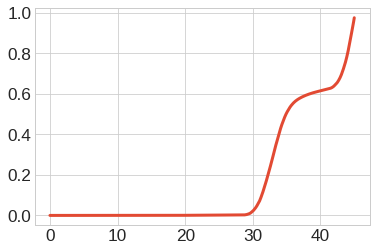

In [6]:
plt.plot(times, ppa_av)

I'm confused. The average patch projection area seems very sensitive to the initial perturbation of the coordinates of the perichondrial cells. Which value did I choose??? I chose 0.1 (I checked).

# Runs without perturbation of the initial coordinates

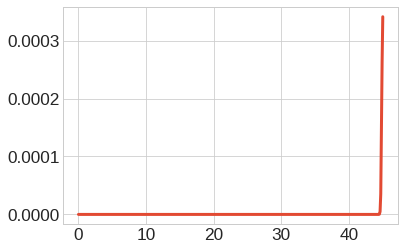

In [9]:
dir_no_perturbation = 'exp-effect_repulsion_and_orientation/20200226-150623'
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_no_perturbation + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_no_perturbation + str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10
plt.plot(times, ppa_av)

# Now let us run the random cell division direction case - no perturbation first

I also think we could maybe use a lower activation percentage, but let's leave it consistent for now. (Simulations would be faster!)

In [10]:
output_directory = 'exp-effect_repulsion_and_orientation/' + time.strftime("%Y%m%d-%H%M%S") +'/'
flags = ' --sbt' # synchronized birth times
flags = flags + ' --T 45.0' # final time 45h
flags = flags + ' --sw 10' # 10 cells in x direction
flags = flags + ' --sd 20' # 20 cells in y direction
flags = flags + ' --sh 1' # 1 cell in z direction
flags = flags + ' --mu 0.0' # adhesive spring stiffness set to 0 -> repulsion only
flags = flags + ' --A 0.5' # 50% of stem cells activated
flags = flags + ' --F pwq' # PWQ force
flags = flags + ' --mu_R 12.0' # set repulsive spring stiffness to 12.0
#flags = flags + ' --p 0.1' # set maximum perturbation of coordinates to 0.1
flags = flags + ' --rdd' # set random division directions


In [11]:
de.run_simulations_multiple_random_seeds(output_directory, flags=flags, number_of_simulations=10)

nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-161335/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-161335/ --S 1 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-161335/ --S 2 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-161335/ --S 3 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pw

In [12]:
de.run_postprocessing_multiple_random_seeds(10, output_directory)

['/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/0/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/1/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/2/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/3/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/4/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/5/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226-161335/6/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200226

analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN slice encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN axis encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN slice encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(

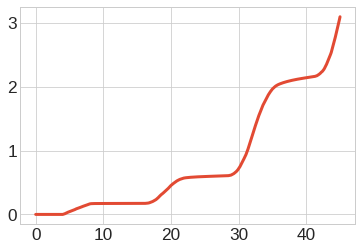

In [13]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10
plt.plot(times, ppa_av)

You can generate a png visualizing clonal patches using

In [7]:
%%bash
pvpython analysis/paraview_show_clonal_patches.py -i /home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/

Input file path is /home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/


Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/Volume/vtkVolumeTextureMapper3D.cxx, line 680
vtkVolumeTextureMapper3D::vtkVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/VolumeOpenGL/vtkOpenGLVolumeTextureMapper3D.cxx, line 57
vtkOpenGLVolumeTextureMapper3D::vtkOpenGLVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/Volume/vtkVolumeTextureMapper3D.cxx, line 680
vtkVolumeTextureMapper3D::vtkVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/VolumeOpenGL/vtkOpenGLVolumeTextureMapper3D.cxx, line 57
vtkOpenGLVolumeTextureMapper3D::vtkOpenGLVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed 

And render the png using

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

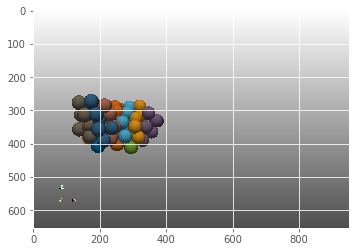

In [15]:
image = mpimg.imread("/home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/patches_t40.png")
plt.imshow(image)